In [413]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from lib.Utility import exportExcelWithTimeStamp, trainLogRegModel, calculate_gain_O25, dumpModel, loadModel
from datetime import date, timedelta
# Alternative package if webreader does not work: pip install yfinance
import numpy as np # Fundamental package for scientific computing with Python
from sklearn.metrics import accuracy_score

features = [
    'AwayWins', 'AwayDraws', 'HomeDraws', 'HomeLosses', 'ConcededGoalsDifference', 'HomeLast3Points', 'EloRatio', 'GoalRatioDifference', 'GoalsSum'
]

threshold = 0.5

In [414]:
dataFromFile = pd.read_excel('data/mergedDataBundesliga.xlsx')
# dataFromFile = pd.read_excel('data/mergedDataFull2.xlsx')
data = dataFromFile.copy()

data['Cluster'] = np.where(data['MatchGoal'] > 2, 1,  0)
# data['Cluster'] = np.where(data['FTHG'] == data['FTAG'], 1, 0) #data['FTR'].map({'D': 0, 'H': 1, 'A': 2}) 
# data = data[data['HomeGoalsCumulative'].notna()]
# data = data[data['AwayGoalsCumulative'].notna()]
# data = data[data['HomePointsCumulative'].notna()]
# data = data[data['AwayPointsCumulative'].notna()]
# data = data[data['HomeGoalsConcededCumulative'].notna()]
# data = data[data['AwayGoalsConcededCumulative'].notna()]
data = data[data['B365>2.5'].notna()]
# data = data[data['B365H'].notna()]
# data = data[data['B365A'].notna()]
data['FormRatio'] = data['HomeForm']/data['AwayForm']
data['RecentFormRatio'] = data['HomeRecentHomeForm']/data['AwayRecentAwayForm']
data['EwmaGoalsScoredRatio'] = data['HomeEwmaGoalsScored']/data['AwayEwmaGoalsScored']
data['UltimoScontroDiretto'] = data['UltimoScontroDiretto'].replace({'H': 1, 'A': 2, 'D': 0})
# data['UltimoScontroDiretto'] = data['UltimoScontroDiretto'].fillna(0)
data['AwayGoalGap'] = data['AwayGoalsCumulative'] - data['HomeGoalsCumulative']
data.replace([np.inf, -np.inf], 100, inplace=True)

# data = data[data['RecentFormRatio'].notna()]
# data = data[data['FormRatio'].notna()]

C:\Users\vitto\AppData\Local\Temp\ipykernel_33908\387723022.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['UltimoScontroDiretto'] = data['UltimoScontroDiretto'].replace({'H': 1, 'A': 2, 'D': 0})


In [415]:
columns_to_check = [
    # 'HomeWins', 'HomeDraws', 'HomeLosses',
    # 'AwayWins', 'AwayDraws', 'AwayLosses',
    'HomeLast3Points',
    # 'HomeEwmaGoalsScored', 'HomeEwmaGoalsConceded', 
    # 'HomeAvgGoalsScored', 
    # 'HomeAvgGoalsConceded', 'HomeEwmaPoints', 

    'AwayLast3Points'
    # , 'AwayAvgGoalsScored', 
    # 'AwayAvgGoalsConceded', 'AwayEwmaPoints',
    # 'AwayEwmaGoalsScored', 
    # 'AwayEwmaGoalsConceded',
    #  'UltimoScontroDiretto' # Se tolgo questa, i risultati sono molto diversi
]

data = data.dropna(subset=columns_to_check)

In [416]:
x_train, x_test, y_train, y_test = train_test_split(data[features], data['Cluster'], test_size= 0.3, random_state= 42,shuffle=True)

x_train = x_train.sort_index()
x_test = x_test.sort_index()
y_train= y_train.sort_index()
y_test = y_test.sort_index()


print (f'X_train: {x_train.shape} \nX_test: {x_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}')


X_train: (876, 9) 
X_test: (376, 9) 
y_train: (876,) 
y_test: (376,)


In [417]:
# model = trainLogRegModel(x_train, y_train)
# dumpModel("Soccer-LogReg-O2.5.joblib", model)
model = loadModel("Soccer-LogReg-O2.5.joblib")

In [418]:
def calculate_gain_O25(row):
    quotaMin = 1.80
    if (row['prediction'] == 1):

        return 0
        if row['B365>2.5'] > quotaMin:
            if row['MatchGoal'] > 2.5:
                return row['B365>2.5']-1
            else:
                return -1
        else:
            return 0
    elif (row['prediction'] == 0):
        
        if row['B365<2.5'] > quotaMin:
            if row['MatchGoal'] < 2.5:
                return row['B365<2.5']-1
            else:
                return -1
        else:
            return 0
    else:
        return 0

In [419]:
# x_test = data[features]
# y_test = data['Cluster']

df = x_test.copy()

df['prediction'] = model.predict(x_test.sort_index())
# df['predictionsDT'] = custom_predict(x_test.sort_index(), threshold, model2)
pred_prob2 = model.predict_proba(x_test.sort_index())

finalDataset = data[data.index.isin(x_test.index)]
finalDataset = finalDataset.copy()


df2 = pd.DataFrame(pred_prob2)
df2.index = df.index
df = df.merge(df2, left_index=True, right_index=True)

finalDataset['prediction'] = df['prediction']
finalDataset['OverProb'] = df[1]
finalDataset['UnderProb'] = df[0]
finalDataset['PredOddOver'] = 1/df[1]
finalDataset['PredOddUnder'] = 1/df[0]

finalDataset['gainO25'] = finalDataset.apply(calculate_gain_O25, axis=1)
finalDataset['Equity'] = finalDataset['gainO25'].cumsum()
equity = finalDataset['gainO25'].sum()
print("Equity", equity)

print(f"Accuracy score: {round(100*accuracy_score(y_test, df['prediction']),2)}%")
exportExcelWithTimeStamp(finalDataset, "Dataframe/", "df.xlsx")

Equity 2.7199999999999998
Accuracy score: 57.98%


In [420]:
from sklearn.metrics import classification_report
# Ottieni il rapporto di classificazione
report = classification_report(y_test, df['prediction'], output_dict=True)
print(report)
# Stampa l'accuratezza per ciascuna classe
for class_name, metrics in report.items():
    if class_name.isdigit():  # Verifica che si tratti di una classe e non di un aggregato (es. accuracy globale)
        print(f"Classe {class_name}: Precision = {metrics['precision']:.2f}")
        # print(f"Classe {class_name}: Recall (Accuratezza della classe) = {metrics['recall']:.2f}")
        # print(f"Classe {class_name}: F1-score = {metrics['f1-score']:.2f}")

{'0': {'precision': 0.45454545454545453, 'recall': 0.3741496598639456, 'f1-score': 0.4104477611940298, 'support': 147.0}, '1': {'precision': 0.6392156862745098, 'recall': 0.7117903930131004, 'f1-score': 0.6735537190082644, 'support': 229.0}, 'accuracy': 0.5797872340425532, 'macro avg': {'precision': 0.5468805704099822, 'recall': 0.542970026438523, 'f1-score': 0.5420007401011471, 'support': 376.0}, 'weighted avg': {'precision': 0.5670174839761823, 'recall': 0.5797872340425532, 'f1-score': 0.5706904855011036, 'support': 376.0}}
Classe 0: Precision = 0.45
Classe 1: Precision = 0.64


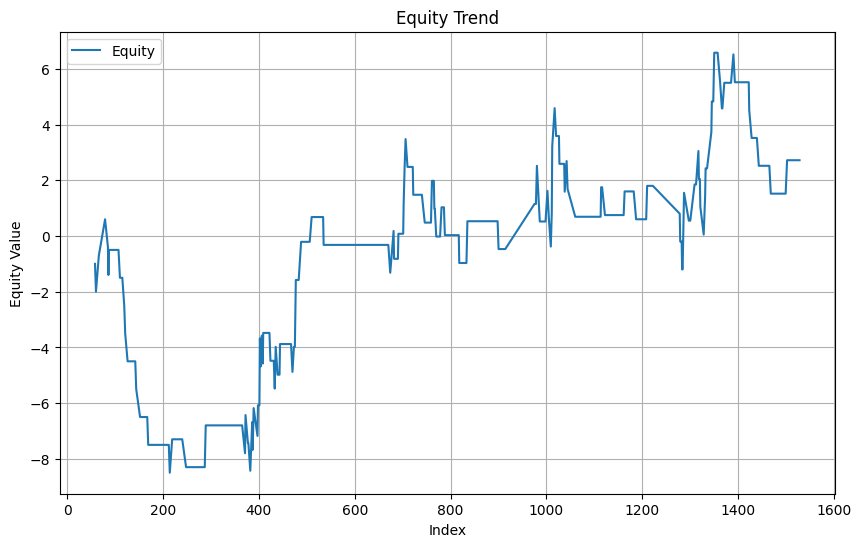

In [421]:
import matplotlib.pyplot as plt

# Supponiamo che il tuo dataframe si chiami 'df'
# Se il dataframe contiene una colonna chiamata 'equity'
plt.figure(figsize=(10,6))
plt.plot(finalDataset['Equity'], label='Equity')

# Impostiamo titolo e label
plt.title('Equity Trend')
plt.xlabel('Index')
plt.ylabel('Equity Value')

# Aggiungiamo una griglia e la legenda
plt.grid(True)
plt.legend()

# Mostriamo il grafico
plt.show()


[ 0.03328047 -0.0028327  -0.0028327   0.03328047  0.00420153  0.01393435
 -0.09405459  0.0105906   0.00063466]


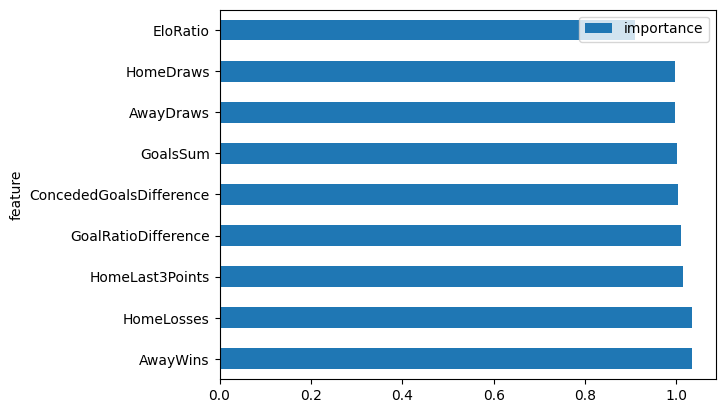

In [422]:
import math
print(model.coef_[0])
w =  model.coef_[0]
feature_importance = pd.DataFrame(features, columns = ["feature"])
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
 
from sklearn.linear_model import LogisticRegression
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()

In [423]:
# dumpModel("Soccer-LogReg-O2.5.joblib", model)